In [1]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import re
import copy
from experiments_utils import load_logs_pickle, has_bidi, has_dilation_base, has_res_block_size, has_smyl_residual, has_n_layers, get_experiment_label, get_experiment_metrics_from_all_folds, get_experiments_samples

grid_pkl = "gridsearch_results.pkl"

layer1_dynamic_lrlow_path = os.path.join('logs', 'multi_layer_dynamic1l')
layer1_dynamic_lrlow = 'gridsearch_results.pkl'
layer1_dynamic_lrlow_results = load_logs_pickle(layer1_dynamic_lrlow_path, layer1_dynamic_lrlow)

layer1_static_path = os.path.join('logs', 'multi_layer_static')
layer1_static = 'gridsearch_results_1l.pkl'
layer1_static_results = load_logs_pickle(layer1_static_path, layer1_static)

layern_static_path = os.path.join('logs', 'multi_layer_static')
layern_static = 'gridsearch_results.pkl'
layern_static_results = load_logs_pickle(layern_static_path, layern_static)

layer1_dyn_path = os.path.join('logs', 'multi_layer_dynamic_1l_300')
layer1_dyn = 'gridsearch_results.pkl'
layer1_dyn_results = load_logs_pickle(layer1_dyn_path, layer1_dyn)

layer10_path = os.path.join('logs', 'multi_layer_dynamic_10l')
layer = 'gridsearch_results.pkl'
layer10_results = load_logs_pickle(layer10_path, layer)
layer1_path = os.path.join('logs', 'multi_layer_dynamic_1l_minlr103')
layer1_results = load_logs_pickle(layer1_path, layer)

dyn_no_dil_base_path = os.path.join('logs', 'multi_layer_dynamic_no_dilation_base')
dyn_no_dil_base = 'gridsearch_results.pkl'
dyn_no_dil_base_results = load_logs_pickle(dyn_no_dil_base_path, dyn_no_dil_base)

static_dilated_path = os.path.join('logs', 'multi_layer_dilation_base')
static_dilated = 'gridsearch_results.pkl'
static_dilated_results = load_logs_pickle(static_dilated_path, static_dilated)

dynamic_1l_no_layernorm_path = os.path.join('logs', 'multi_layer_dynamic_1l_no_layernorm')
dynamic_1l_no_layernorm = 'gridsearch_results.pkl'
dynamic_1l_no_layernorm_results = load_logs_pickle(dynamic_1l_no_layernorm_path, dynamic_1l_no_layernorm)

exp_path = os.path.join('logs', 'multi_layer_smyl_layernorm')
no_bidi = 'gridsearch_results_no_bidirectional.pkl'
no_bidi_results = load_logs_pickle(exp_path, no_bidi)

general_single_path = os.path.join('..', '07_single_layer_rnns', 'mac_logs', 'general_rnn_gridsearch')
single_layer_results = load_logs_pickle(general_single_path, grid_pkl)
lstm_50 = single_layer_results[2]

dynamic_lr_exp_path = os.path.join('logs', 'multi_layer_smyl_layernorm_dynamic_lr')
layers_2 = 'gridsearch_results_02_layers.pkl'
layers_2_results = load_logs_pickle(dynamic_lr_exp_path, layers_2)

dynamic_lr_46_exp_path = os.path.join('logs', 'multi_layer_smyl_layernorm_dynamic_246')
dynamic_lr_46 = 'gridsearch_results.pkl'
dynamic_lr_46_results = load_logs_pickle(dynamic_lr_46_exp_path, dynamic_lr_46)

dynamic_lr_1l_exp_path = os.path.join('logs', 'multi_layer_dynamic_1l')
dynamic_lr_1l = 'gridsearch_results.pkl'
dynamic_lr_1l_results = load_logs_pickle(dynamic_lr_1l_exp_path, dynamic_lr_1l)

Define functions for data analysis

In [11]:
from sklearn.preprocessing import FunctionTransformer
from types import FunctionType
import numpy as np
import utils

def get_exp_name(exp):
    name = ""
    for i, key in enumerate(exp.keys()):
        if key != 'metrics_per_fold':
            if i > 0:
                name += " "
            if isinstance(exp[key], str):
                name += exp[key]
            elif isinstance(exp[key], FunctionTransformer):
                return exp[key].func.__name__
            elif isinstance(exp[key], bool):
                name += key if exp[key] else "not "+ key
            elif isinstance(exp[key], FunctionType):
                name += exp[key].__qualname__
            else:
                key_parts = key.split("-")
                last_part = key_parts[-1]
                key_words = last_part.split("_")
                shortcut = "".join([word[0] for word in key_words]) if len(key_words) > 1 else key_words[0]
                name += shortcut + "=" + str(exp[key])

    #name = name.replace("dataset-", "").replace("_", " ").replace("-", " ")
    name = name.capitalize()
    return name

def get_train_loss_metric_filename(exp, fold_num: int = 0, remove_non_filename_chars: bool = True, first_n_letters: int = 1, decimals: int = 2):
    exp_no_results = copy.deepcopy(exp)
    exp_no_results.pop('metrics_per_fold', None)
    short_string = utils.get_dictionary_short_string(exp_no_results, first_n_letters=first_n_letters, decimals=decimals, remove_non_filename_chars=remove_non_filename_chars)
    filename = short_string + "_fold" + str(fold_num) + ".csv"
    return filename

def get_folds_data(exp, exp_path):
    folds_data = []
    for fold_num in range(10):
        train_loss_filename = get_train_loss_metric_filename(exp, fold_num=fold_num)
        #mnl_2-mrcpu_50-mdb_None-mrbs_None-msr_True-mln_True-mb_True-toplr_0.00-te_600-tac_600_fold0.csv
        with open(os.path.join(exp_path, "training_loss_metrics", train_loss_filename), "r") as f:
            train_loss_df = pd.read_csv(f)
        train_loss_df = train_loss_df[["epoch", "root_mean_squared_error", "val_root_mean_squared_error"]]
        folds_data.append(train_loss_df)
    return folds_data

def get_learning_rate_data(exp, exp_path):
    lr_data = []
    for fold_num in range(10):
        train_loss_filename = get_train_loss_metric_filename(exp, fold_num=fold_num)
        #mnl_2-mrcpu_50-mdb_None-mrbs_None-msr_True-mln_True-mb_True-toplr_0.00-te_600-tac_600_fold0.csv
        with open(os.path.join(exp_path, "training_loss_metrics", train_loss_filename), "r") as f:
            train_loss_df = pd.read_csv(f)
        lr_data.append(train_loss_df[["epoch", "learning_rate"]])
    return lr_data

def prepare_loss_data_for_plotting(folds_data):
    epochs = range(0, len(folds_data[0]))
    for i, df in enumerate(folds_data):
        df['fold'] = i
    all_data = pd.concat(folds_data)

    # Group by epoch
    grouped = all_data.groupby('epoch')

    # Pre-compute all metrics for both training and validation losses
    mean_train_losses = grouped['root_mean_squared_error'].mean().values
    q1_train_losses = grouped['root_mean_squared_error'].quantile(0.25).values
    q3_train_losses = grouped['root_mean_squared_error'].quantile(0.75).values

    mean_val_losses = grouped['val_root_mean_squared_error'].mean().values
    q1_val_losses = grouped['val_root_mean_squared_error'].quantile(0.25).values
    q3_val_losses = grouped['val_root_mean_squared_error'].quantile(0.75).values

    return epochs, mean_train_losses, q1_train_losses, q3_train_losses, mean_val_losses, q1_val_losses, q3_val_losses

def plot_mean_loss_with_quartiles(folds_data, label: str):
    
    epochs, mean_train_losses, q1_train_losses, q3_train_losses, mean_val_losses, q1_val_losses, q3_val_losses = prepare_loss_data_for_plotting(folds_data)

    # Training Loss
    #plt.plot(epochs, mean_train_losses, label=f'Mean Training Loss {label}')
    #plt.fill_between(epochs, q1_train_losses, q3_train_losses, alpha=0.3)#, label='Training Loss Q1-Q3 Range')

    # Validation Loss
    #plt.plot(epochs, mean_val_losses, label=f'Mean Validation Loss {label}')
    plt.plot(epochs, mean_val_losses, label=f'{label}')
    plt.fill_between(epochs, q1_val_losses, q3_val_losses, alpha=0.15)#, label='Validation Loss Q1-Q3 Range')

def plot_all_losses(all_folds_data, labels, xlim=None, ylim=None):
    # Sort by label
    
    all_folds_data_sorted, labels_sorted = all_folds_data, labels
    #paired_list = list(zip(all_folds_data, labels))
    #paired_list_sorted = sorted(paired_list, key=lambda x: x[1])
    #all_folds_data_sorted, labels_sorted = zip(*paired_list_sorted)

    # Plotting
    for folds_data, label in zip(all_folds_data_sorted, labels_sorted):
        plot_mean_loss_with_quartiles(folds_data, label)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Mean Validation Loss with Quartiles per Epoch')
    plt.legend()
    plt.yscale('log')
    plt.xlim(xlim[0], xlim[1]) if xlim else None
    plt.ylim(ylim[0], ylim[1]) if ylim else None
    plt.show()

In [12]:

# find the smyl_residual and all other none
all_folds_data = []
experiments_names = []
all_experiments = []
experiments_samples = {} # for pariwise comparison
learning_rates, lr_names = [], []

# Experiment with 1 layer fixed learning rate
exp, path = layer1_static_results[0], layer1_static_path
fd = get_folds_data(exp, path)
all_folds_data.append(fd)
exp_name = get_experiment_label(exp)
all_experiments.append(exp)
experiments_names.append(exp_name)
learning_rates.append(get_learning_rate_data(exp, path))
lr_names.append(exp_name)

#exps, path = layer1_results, layer1_path
exps, path = layer1_dyn_results, layer1_dyn_path # We use only the dynamic one. There is also static experiment which has too low learning rate
for exp in exps:
    has_dynamic_lr = "training-additional_callbacks" in exp and exp["training-additional_callbacks"]
    if not has_dynamic_lr:
        continue
    all_experiments.append(exp)
    folds_data = get_folds_data(exp, path)
    all_folds_data.append(folds_data)
    #exp_name = f"l{exp["model-num_layers"]} u{exp["model-rnn_cell_params-units"]} {"lrDynamic" if has_dynamic_lr is not None else "lrStatic"}"
    exp_name = get_experiment_label(exp)
    experiments_names.append(exp_name)
    learning_rates.append(get_learning_rate_data(exp, path))
    lr_names.append(exp_name)

exps, path = layer10_results, layer10_path
for exp in reversed(exps):
    has_dynamic_lr = "training-additional_callbacks" in exp and exp["training-additional_callbacks"]
    if not has_dynamic_lr:
        continue
    all_experiments.append(exp)
    folds_data = get_folds_data(exp, path)
    all_folds_data.append(folds_data)
    exp_name = get_experiment_label(exp)
    experiments_names.append(exp_name)
    learning_rates.append(get_learning_rate_data(exp, path))
    lr_names.append(exp_name)

exps, path = layern_static_results, layern_static_path
for exp in exps:
    all_experiments.append(exp)
    folds_data = get_folds_data(exp, path)
    all_folds_data.append(folds_data)
    exp_name = get_experiment_label(exp)
    experiments_names.append(exp_name)
    #lr_names.append(exp_name)
    #experiments_names.append(get_train_loss_metric_filename(exp, fold_num=0).replace("_fold0.csv", ""))
    #learning_rates.append(get_learning_rate_data(exp, path))
    
## The worst performing as it does not have chance to learn before too low lr
#exp, path = layer1_dynamic_lrlow_results[0], layer1_dynamic_lrlow_path
#fd = get_folds_data(exp, path)
#all_folds_data.append(fd)
#experiments_names.append("1_layer_dynamic_lr_0.0001")
#learning_rates.append(get_learning_rate_data(exp, path))
#lr_names.append(get_exp_name(exp))


['l1 lrFixed', 'l1 lrDynamic', 'l2 lrDynamic', 'l4 lrDynamic', 'l6 lrDynamic', 'l10 lrDynamic', 'l2 lrFixed', 'l4 lrFixed', 'l6 lrFixed', 'l10 lrFixed']


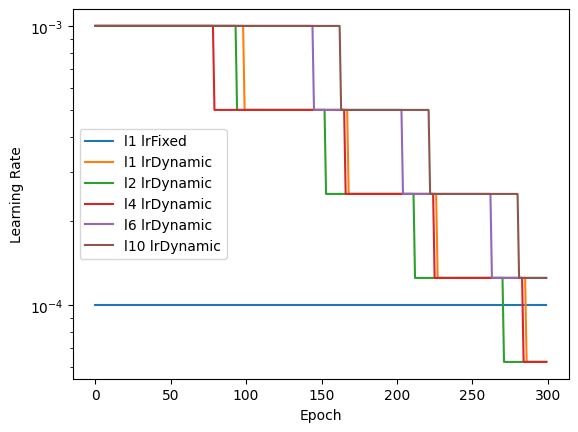

Nl=10 units=50 db=none rbs=2 model-smyl_residual model-layer_normalization not model-bidirectional lr=0.0001 epochs=300 ac=none


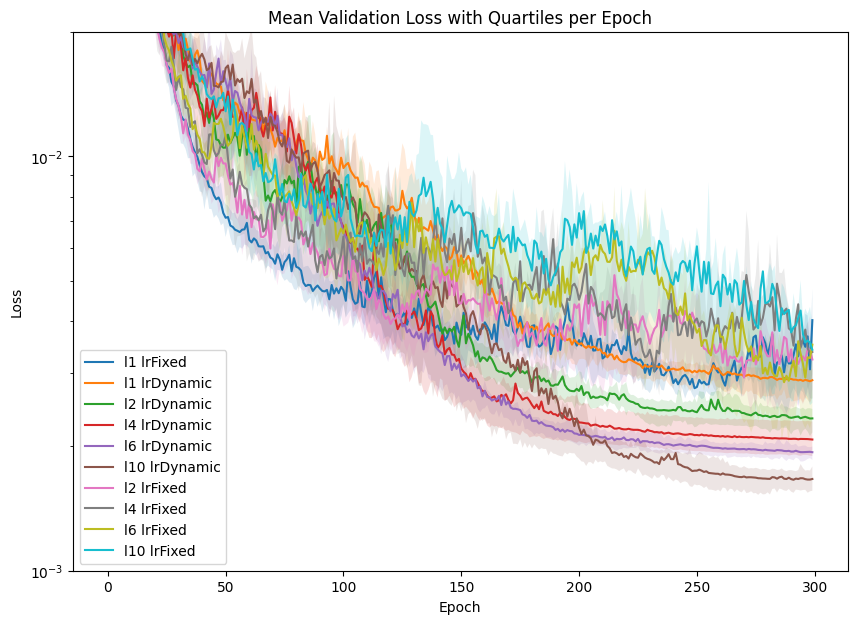

In [13]:
# 1. Get critical difference diagram
from critdd import Diagram
exp_samples = get_experiments_samples(all_experiments, experiments_names)

x=np.array(list(exp_samples.values()))
treatment_names = list(exp_samples.keys())
print(treatment_names)
x = x.T
diagram = Diagram(x,
    treatment_names=treatment_names,
    maximize_outcome = False,
)

diagram.to_file(
    "critdd_dynamic_lr.tex",
    alpha=0.05,
    adjustment="holm",
    reverse_x=True,
)

# 2. Plot learning rates

for lr_data, name in zip(learning_rates, lr_names):
    #for i, fold in enumerate(lr_data):
    i = 0
    fold = lr_data[i]
    plt.plot(fold['epoch'], fold['learning_rate'], label=name)
#plt.plot([0]['epoch'], layer_2_learning_rate[0]['learning_rate'], label='2_layers_dynamic_lr')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.show()
print(get_exp_name(exp))

plt.figure(figsize=(10, 7))

# 3. Plot losses

#plot_all_losses(all_folds_data, experiments_names)#, xlim=(25, 301), ylim=(0.0015, 0.025))
plot_all_losses(all_folds_data, experiments_names, ylim=(0.001, 0.02))